In [97]:
import subprocess
import time
import pandas as pd
from collections import defaultdict
import copy
from itertools import combinations_with_replacement,combinations
import sys
import os

filename='gh_lyso_c_g_ch_ala.txt'
prtns=filename.split('.')[0]
# os.mkdir(prtns)

class per_ident:
    def __init__(self,file):
        self.acc,self.seq=[],[]
        with open(file,'r') as inpt:
            for i in inpt:
                if i.startswith('>'):
                    self.acc.append(i)
                else:
                    self.seq.append(i)
                    
    def create_files(self):
        total_data=[]
        for i in range(len(self.acc)):
            main_out=open('main_temp.txt','w')
            main_out.write(self.acc[i]+self.seq[i])
            main_out.close()
            for j in range(i+1,len(self.acc)):
                out=open('temp.txt','w')
                out.write(self.acc[j]+self.seq[j])
                out.close()
                data=self.blast('main_temp.txt','temp.txt')
                if data==[]:
                    data=['\t'.join([self.acc[i].rstrip().split(' ')[0][1:],self.acc[j].rstrip().split(' ')[0][1:],'0','0','0'])]# change the number of 0 based on number parameters taken
                total_data.extend(data)
        final_out=open(f'{prtns}_pairwise_blastp.txt','w')
        for k in total_data:
            final_out.write(k+'\n')
        final_out.close()
        
    def blast(self,file1,file2):
        data=[]
        subprocess.run(f' blastp -query {file1} -subject {file2} -outfmt "6 qseqid sseqid pident qcovs qcovhsp" -out result.txt',
               shell=True,stdout=subprocess.PIPE,check=True,universal_newlines=True)
        with open('result.txt','r') as inpt:
            for i in inpt:
                data.append(i.rstrip())
        return data
    
class pairwise_matrix:
    def __init__(self,file3):
        self.temp=[]
        self.multi_hit=defaultdict(list)
        with open(file3,'r') as inpt:
            for i in inpt:
                j=i.rstrip().split('\t')
                name=j[0]+'&'+j[1]
                self.temp.append(j)
                self.multi_hit[name].append([float(fl_i) for fl_i in j[2:]])
    def matrix(self,typ,pq):
        if pq=='PI':
            noo=0
        elif pq=='QC':
            noo=-1
        else:
            sys.exit('Dude!!! what do you want % identity or % query coverage...')
        self.collect=defaultdict(list)
        for i,j in dict(self.multi_hit).items():
            j=sorted(j,key=lambda x:x[-1], reverse= True)
            j=j[0] # hsp with high query coverage is taken
            if j[0]>=pi_cutoff and j[-1]>=qc_cutoff: # pi=percentage identity and qc=query coverage
                j_1=j
            else:
                j_1=[0,0,0]
            i1=i.split('&')
            self.collect[i1[0]].append(j_1[noo])
        self.collect[i1[1]]=[] # for the last accession number, eg 8&9 is last in list and we need 9.
        self.collect=dict(self.collect)
        le=len(self.collect)
        for k,l in self.collect.items():
            diff=le-len(l)
            tem=[]
            for m in range(diff):
                tem.append(0)
            l=tem+l
            self.collect[k]=l
        df=pd.DataFrame(self.collect, index=self.collect.keys()).astype(float)
        label=[]
        for each in alpha.acc:
            tt=each.rstrip()[1:].split('$')[typ]
            label.append(tt)
        df.index=df.columns=label
        for ro_co in range(le):
            df.iloc[ro_co,ro_co]=-1
        dff=copy.copy(df)
        return dff.round(decimals=1)
    
class matrix_analysis:
    def __init__(self,ax,nam):
        self.nam=nam
        self.uniq=[]
        self.each_len=[]
        for eaa in list(ax.index):
            if eaa not in self.uniq:
                self.uniq.append(eaa)
#         self.uniq=['c','lalba']
#         self.uniq=['g','c','ch']
        self.name='_'.join(self.uniq)
        self.comb = list(combinations_with_replacement(self.uniq, 2))
        out=open(f'{prtns}/{prtns}_compare_pair_identity_{pi_cutoff}_{qc_cutoff}_{self.nam}.txt','w')
        self.dat={}
        for jj in self.comb:
            temp=jj[0]+','+jj[1]
        #     print(temp)
            self.dat[temp]=[]
            rl=len(ax.index)
            cl=len(ax.columns)
            for kk in range(rl):
                for ll in range(cl):
                    if kk+ll <rl:
                        if ax.index[kk]==jj[0] and ax.columns[kk+ll]==jj[1]:
                            self.dat[temp].append(float(ax.iloc[kk,kk+ll]))
            hj=[xy for xy in list(self.dat[temp]) if xy != -1]
            ij=copy.copy(hj)
            hj.sort()
            self.dat[temp]=hj
            self.each_len.append(len(hj))
            temp1=12-len(temp)
            temp2=f'{hj[:5]}'[1:-1]
            temp21=36-len(temp2)
            temp3=f'{hj[-5:]}'[1:-1]
#             print(temp,' '*temp1,'min:',temp2,' '*temp21,'max:',temp3,'\n')
            out.write(temp+' '*temp1+'min: '+temp2+' '*temp21+'max: '+temp3+'\n')
        out.close()
        
    def overlapping(self):
        common={}
        stat={}
        cwr=list(combinations(self.uniq,2))
        for i in cwr:
            x=i[0]+','+i[1]
            y=i[0]+','+i[0]
            z=i[1]+','+i[1]
            for j in [y,z]:
                temp=[q for q in self.dat[x] if q>=min(self.dat[j])]
                common[f'{x}/{j}']=temp
                stat[f'{x}/{j}']=[len(self.dat[x]),len(self.dat[j]),min(self.dat[j]),len(temp)]
        dfuc=pd.DataFrame(stat,index=['#hybrid(H)','#identical(I)','min(%I)','H>min(%I)']).astype(int)
        dfuc.to_excel(f'{prtns}/{prtns}_per_ident_stat_{pi_cutoff}_{qc_cutoff}_{self.nam}.xlsx')
        
    def to_excel(self):
        graph_data=copy.copy(self.dat)
        for gh1,gh2 in graph_data.items():
            if max(self.each_len)>len(gh2):
                diff=(max(self.each_len)-len(gh2))*['']
                graph_data[gh1].extend(diff)
        df1=pd.DataFrame(graph_data)
        df1.to_excel(f'{prtns}/{prtns}_per_ident_plot_{pi_cutoff}_{qc_cutoff}_{self.nam}.xlsx',index=False)
        
class pi_qc_scatter:
    def __init__(self,data):
        self.data=data
        self.label=self.data.columns
        
    def each_com(self):
        l=len(self.label)
        tem=defaultdict(list)
        for i in range(l):
            for j in range(i+1,l):
                tem[f'{self.label[i]},{self.label[j]}'].append(self.data.iloc[j,i])
        return dict(tem)

start=time.perf_counter()
pi_cutoff=0
qc_cutoff=0
alpha=per_ident(filename)
# alpha.create_files()

# .matrix(a,b) where a=0:'acc',1:'prtn',2:'ec',3:'org',4:'species',5:'ghf', b=PI:per_ident,QC:query_cover
pi_qc={}
c={}
a=pairwise_matrix(f'{prtns}_pairwise_blastp.txt')
for part in ['PI','QC']:
    pi_qc[part]=a.matrix(1,part)
    b=matrix_analysis(pi_qc[part],part)
    b.overlapping()
    b.to_excel()
    c[part]=pi_qc_scatter(pi_qc[part]).each_com()
d={}
for c1 in list(c[part].keys()):
    goat=[]
    for c2,c3 in zip(c['PI'][c1],c['QC'][c1]):
        goat.append([c2,c3])
    d[c1]=sorted(goat,key=lambda x:x[0])
    
a3=pi_qc['PI'].T+pi_qc['QC']
a3.to_excel(f'{prtns}/{prtns}_pariwise_blastp_matrix_{pi_cutoff}_{qc_cutoff}.xlsx')
# -2 in the matrix represent the % identity and % query coverages diagonal values got added (-1-1=-2)
stop=time.perf_counter()
print('The total time take:',round((stop-start),2),'sec')

The total time take: 3.24 sec


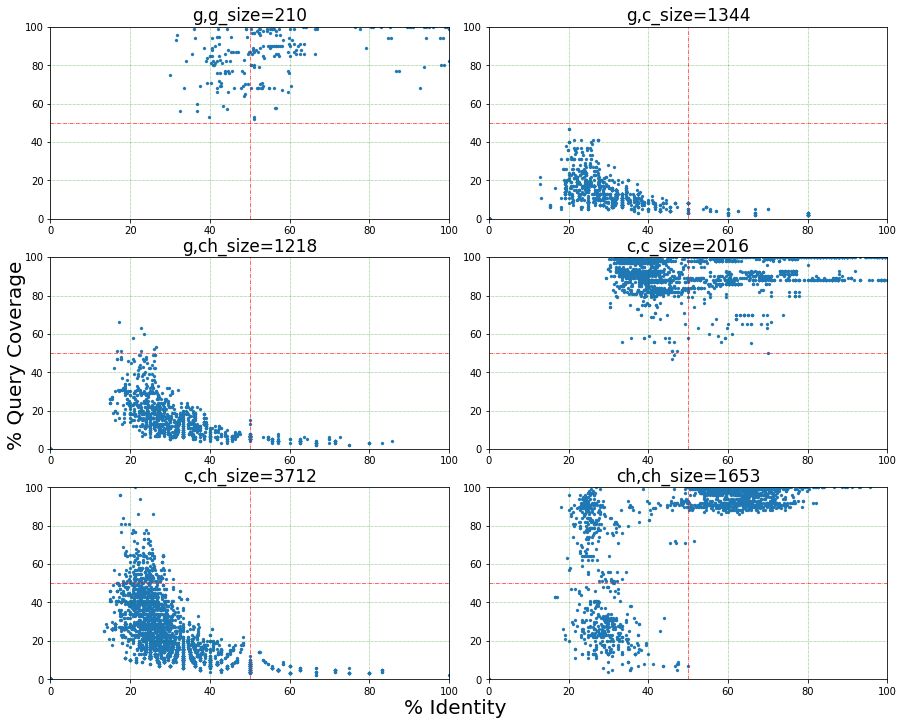

In [189]:
import matplotlib.pyplot as plt
new_list=list(combinations_with_replacement(['g','c','ch'],2))
new_cord=list(combinations_with_replacement([no for no in range(3)],2))
fig, axs = plt.subplots(3,2,figsize=(15, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
ref1=[z for z in range(101)]
ref2=[50 for z in range(101)]
for axis,ax in zip(new_list,axs.ravel()):
    new_axis=axis[0]+','+axis[1]
#     print(new_axis)
    u1=[u[0] for u in d[new_axis]]
    v1=[v[1] for v in d[new_axis]]
    ax.scatter(u1,v1,linewidth=0.1,s=10)
    ax.plot(ref1,ref2,color='r',linestyle = '-.',linewidth=0.6)
    ax.plot(ref2,ref1,color='r',linestyle = '-.',linewidth=0.6)
    ax.set_title(f'{new_axis}_size={len(u1)}',fontsize=17)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.grid(color = 'green', linestyle = ':', linewidth = 0.5)
    


fig.text(0.5, 0.085, '% Identity', ha='center',fontsize=20)
fig.text(0.085, 0.5, '% Query Coverage', va='center', rotation='vertical',fontsize=20)
plt.show()
fig.savefig('lyso_pi_qc.png',dpi=300)

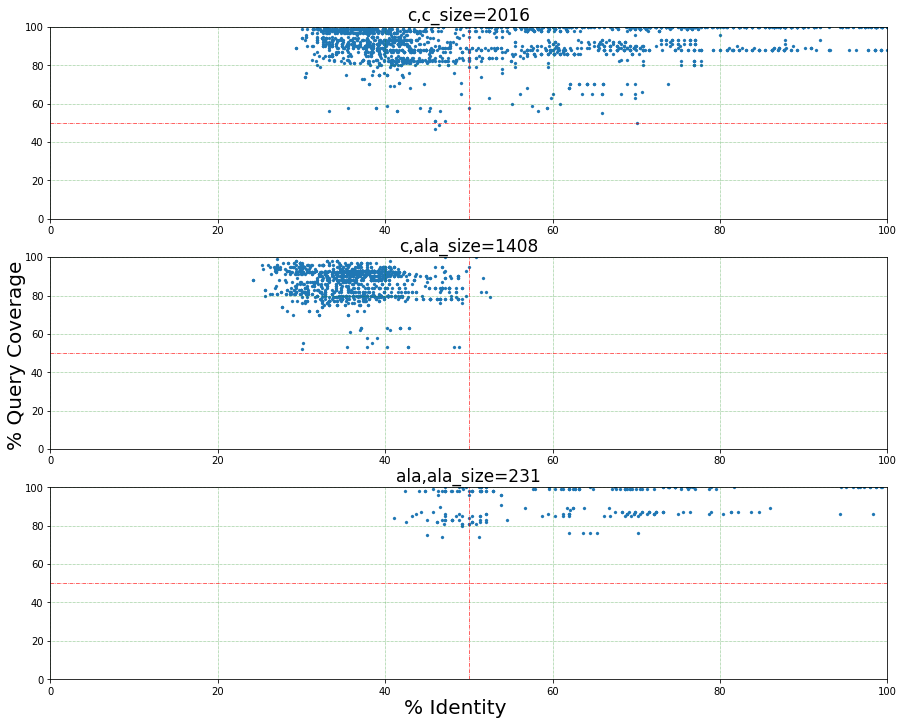

In [190]:
new_list=list(combinations_with_replacement(['c','ala'],2))
# new_cord=list(combinations_with_replacement([no for no in range(3)],2))
fig, axs = plt.subplots(3,1,figsize=(15, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
ref1=[z for z in range(101)]
ref2=[50 for z in range(101)]
for axis,ax in zip(new_list,axs.ravel()):
    new_axis=axis[0]+','+axis[1]
#     print(new_axis)
    u1=[u[0] for u in d[new_axis]]
    v1=[v[1] for v in d[new_axis]]
    ax.scatter(u1,v1,linewidth=0.1,s=10)
    ax.plot(ref1,ref2,color='r',linestyle = '-.',linewidth=0.6)
    ax.plot(ref2,ref1,color='r',linestyle = '-.',linewidth=0.6)
    ax.set_title(f'{new_axis}_size={len(u1)}',fontsize=17)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.grid(color = 'green', linestyle = ':', linewidth = 0.5)
    


fig.text(0.5, 0.085, '% Identity', ha='center',fontsize=20)
fig.text(0.085, 0.5, '% Query Coverage', va='center', rotation='vertical',fontsize=20)
fig.savefig('lyso_ala_pi_qc.png',dpi=300)
plt.show()